In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from time import sleep

In [2]:
def init_full_dataset(dates_range):
    dates = []
    dataset = []
    for date in dates_range:
        file =f'{name}_{date}.npy'
        array = np.load(f'./kara/{file}')
        dates.append(date)
        dataset.append(array)
    return dates, np.array(dataset)

In [3]:
def preprocess_date(data_string):
    year, month, day = int(data_string[:4]), int(data_string[4:6]), int(data_string[6:8])
    return abs(np.sin(np.pi * (((30*month-30)+day) / 365)))

In [4]:
def create_dataset_for_model(data, dates):
    # шаг между изображениями берем 7 дней
    # обучение будет на 5 годах (52*2 недель), прогноз на 1 год (52 недель)
    x_data = []
    x_dates = []
    y_data = []
    y_dates = []
    
    step = 7
    history_length = 52 * 2 * step
    forecast_length = 52 * step
    for i in range(len(data)- history_length - forecast_length):
        x = data[i:i+history_length:step]
        y = data[i+history_length:i+history_length+forecast_length:step]
        #x = np.expand_dims(x, axis=1) 
        # = np.expand_dims(y, axis=1)
        x_data.append(x)
        x_dates.append(np.array(list(map(preprocess_date,dates[i:i+history_length:step]))).reshape(-1,1))
        y_data.append(y)
        y_dates.append(np.array(list(map(preprocess_date,dates[i+history_length:i+history_length+forecast_length:step]))).reshape(-1,1))
    return (x_data), x_dates, (y_data), y_dates

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X_list, Y_list, Date_list):
        self.X_list = X_list
        self.Y_list = Y_list
        self.Date_list = Date_list

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        X = torch.from_numpy(self.X_list[idx])
        Y = torch.from_numpy(self.Y_list[idx])
        Date = torch.from_numpy(self.Date_list[idx])
        return X, Y, Date

In [6]:
class CreateData():
    def __init__(self, X, Y, Date, batch_size=16, train_prop=0.9):
        self.batch_size = batch_size
        self.train_size = int(len(X) * train_prop)
        self.X = X
        self.Y = Y
        self.Date = Date

    def setup(self):
        train_dataset = CustomDataset(self.X[:self.train_size], self.Y[:self.train_size],self.Date[:self.train_size])
        test_dataset = CustomDataset(self.X[self.train_size:], self.Y[self.train_size:], self.Date[self.train_size:])
        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset
        

In [7]:
class ForecastModel(nn.Module):
    def __init__(self, input_channels=104, output_channels=52, time_embed_dim=104):
        super(ForecastModel, self).__init__()
        
        self.upsample_layer = nn.Upsample(size=(140, 120), mode='bilinear', align_corners=False)
        self.resizing = nn.AdaptiveAvgPool2d((140, 120))
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 116, kernel_size=3, padding=0), 
            nn.BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),  
            nn.ReLU(inplace=True),
            
            nn.Conv2d(116, 128, kernel_size=3, padding=0),  
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 140, kernel_size=3, padding=0),  
            nn.BatchNorm2d(140), 
            nn.ReLU(inplace=True),

            nn.Conv2d(140, 152, kernel_size=3, padding=0),  
            nn.BatchNorm2d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),

            nn.Conv2d(152, 164, kernel_size=3, padding=0),  
            nn.BatchNorm2d(164, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
        )
        
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(164, 162, kernel_size=3, padding=2),   
            nn.BatchNorm2d(162, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(162, 140, kernel_size=3, padding=2),  
            nn.BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(140, 118, kernel_size=3, padding=2),   
            nn.BatchNorm2d(118, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(118, 96, kernel_size=3, padding=2),  
            nn.BatchNorm2d(96), 
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(96, 52, kernel_size=3, padding=2),  
            nn.BatchNorm2d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(52, output_channels, kernel_size=3, padding=1),   
            
        )


        
    def forward(self, x, time_steps):
        batch_size = x.shape[0]
        time_steps = self.upsample_layer(time_steps.view(batch_size, 104, 1, 1))
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.resizing(x)
        return x

In [8]:
def train_model(model, epochs, train_params):
    
    optimizer, criterion, device = train_params['optimizer'], train_params['criterion'], train_params['device']
    data_loss = []
    model.train().to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, targets, dates in tepoch:  
                tepoch.set_description(f"Epoch {epoch}")
                images, targets, dates = images.float().to(device), targets.float().to(device), dates.float().to(device)
            
                optimizer.zero_grad()
                outputs = model(images, dates)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
                #sleep(0.1)
            
        data_loss.append(epoch_loss / len(train_loader))
    return data_loss, model

# Загружаем данные

In [9]:
name = 'osi_masie'
all_dates, all_matrices = init_full_dataset(pd.date_range('20060101', '20240831').strftime('%Y%m%d'))

In [10]:
X_data, X_date, Y_data, Y_date = create_dataset_for_model(all_matrices, all_dates)

In [11]:
loader = CreateData(X_data, Y_data, X_date, batch_size=16)
loader.setup()
train_loader = loader.train_dataloader()
test_loader = loader.test_dataloader()

# Инициализируем и обучаем модель

In [12]:
multimodal_model = ForecastModel()  
multimodal_params = {'optimizer': optim.Adam(multimodal_model.parameters(), lr=0.001),
                     'criterion': nn.L1Loss(),
                     'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")}

In [13]:
loss, multimodal_model = train_model(multimodal_model, 100, multimodal_params)

Epoch 99: 100%|██████████████████████████████████████████████████████| 323/323 [04:19<00:00,  1.25batch/s, loss=0.0541]


In [14]:
torch.save(multimodal_model.state_dict(), 'multimodal_model_forecast.pth')

# Предикт модели

In [21]:
multimodal_params_test = {'criterion': nn.L1Loss(),
                     'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")}

In [37]:
def test_model(model, params: dict):
    
    criterion, device = params['criterion'], params['device']
    with torch.no_grad():
        total_loss = 0.0
        i = 0
        for batch in tqdm(test_loader, desc="Batches"):
            if i == 0:
                images1, targets1, dates1 = batch
            batch_loss = 0.0
            images, targets, dates = batch    
    
            images, targets, dates = images.float().to(device), targets.float().to(device), dates.float().to(device)
            predict = multimodal_model(images, dates)
            batch_loss = criterion(predict, targets)
    
            total_loss += batch_loss.item()
            i+=1
        avg_loss = total_loss / len(test_loader)
        print('Средняя ошибка MAE:', avg_loss)
    return images1, targets1, dates1

In [38]:
images, targets, dates = test_model(multimodal_model, multimodal_params_test)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 36/36 [00:19<00:00,  1.86it/s]

Средняя ошибка MAE: 0.06870913867735201


In [39]:
def save_gif(
    matrices,
    name: str,
    writer: str = "pillow",
    fps: int = 2,
    interval: int = 10000,
) -> None:
    """
    Saving matrices lika a .gif file

    :param matrices: array of frames
    :param name: filename
    :param writer: writer of frames. Default: pillow
    :param fps: fps. Default: 30
    :param interval: interval between frames in milliseconds. Default: 10
    """
    fig, ax = plt.subplots()
    frames = list(map(lambda x: (ax.imshow(1 - x, cmap='Blues_r'),), matrices))
    ani = animation.ArtistAnimation(fig=fig, artists=frames, interval=interval)
    ani.save(filename=f"{name}.gif", writer=writer, fps=fps)

In [42]:
model_predict = multimodal_model(images.float().to(device), dates.float().to(device)).cpu().detach().numpy()

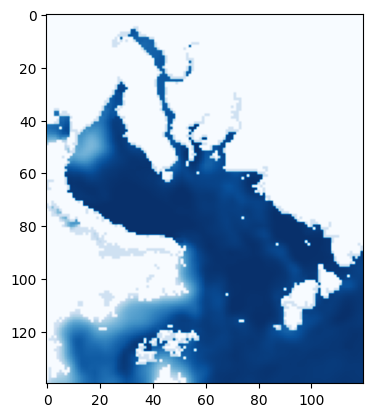

In [48]:
save_gif(targets.cpu().detach().numpy()[-1], 'real_images')

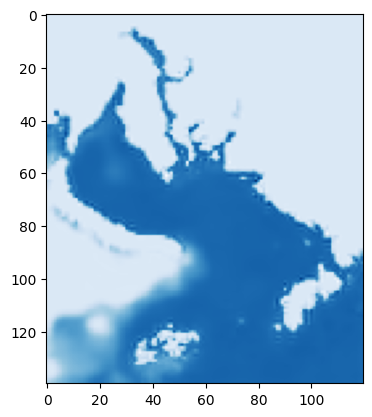

In [49]:
save_gif(model_predict[-1], 'predict_images')

# Анимация

1) Реальные значения

![Анимация реальных значений](./real_images.gif)

2) Предикт

![Анимация предсказанных значение](./predict_images.gif)